<a href="https://colab.research.google.com/github/EmineSener/Computer-Vision-With-Transformer/blob/main/coursera_CV_A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [22]:
import urllib.request
import os
import zipfile
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from shutil import copyfile
import tensorflow as tf

In [23]:
import urllib.request  # Import the urllib module to download data from URLs
import zipfile  # Import the zipfile module to handle ZIP files

# URL from which the data will be downloaded
data_url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"

# Name of the file to be downloaded
data_file_name = "catsdogs.zip"

# Directory where the downloaded file will be saved
download_dir = '/tmp/'

# Downloading the data
urllib.request.urlretrieve(data_url, data_file_name)

# Opening the ZIP file
zip_ref = zipfile.ZipFile(data_file_name, 'r')

# Extracting the ZIP file to the specified directory
zip_ref.extractall(download_dir)

# Closing the ZIP file
zip_ref.close()

Check that the dataset has the expected number of examples.

In [24]:
print("Number of cat images:",len(os.listdir('/tmp/PetImages/Cat/')))
print("Number of dog images:", len(os.listdir('/tmp/PetImages/Dog/')))

Number of cat images: 12501
Number of dog images: 12501


Create some folders that will store the training and test data.
- There will be a training folder and a testing folder.
- Each of these will have a subfolder for cats and another subfolder for dogs.

In [25]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

### Split data into training and test sets

- The following code put first checks if an image file is empty (zero length)
- Of the files that are not empty, it puts 90% of the data into the training set, and 10% into the test set.

In [26]:
import random
from shutil import copyfile
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    """
    source : is path for all dataset
    Training : is path of folder that we want to store training data
    testing:   is path of folder that we want to store testing data
    split_Size : is the ratio of training dataset
    """
    files = [] #will contain the paths of not empty files
    #this part check whether file is empty or not [filter the empty files]
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        #os.path.getsize return the size of file
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE) #determine training length
    testing_length = int(len(files) - training_length) #determine test length
    shuffled_set = random.sample(files, len(files)) #randomize dataset
    training_set = shuffled_set[0:training_length]  #training set
    testing_set = shuffled_set[training_length:]   #test set
    # copy training set from source to destination[training set folder]
    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)#copying statement
    # copy test set from source to destination[testing set folder]
    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination) #copying statement

#source, traing, and test folders for cat and dog
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


Check that the training and test sets are the expected lengths.

In [27]:
print("Number of training cat images", len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print("Number of training dog images", len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print("Number of testing cat images", len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print("Number of testing dog images", len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

# expected output
# Number of training cat images 11250
# Number of training dog images 11250
# Number of testing cat images 1250
# Number of testing dog images 1250

Number of training cat images 12368
Number of training dog images 12372
Number of testing cat images 2368
Number of testing dog images 2372


### Data augmentation (try adjusting the parameters)!

Here, you'll use the `ImageDataGenerator` to perform data augmentation.  
- Things like rotating and flipping the existing images allows you to generate training data that is more varied, and can help the model generalize better during training.  
- You can also use the data generator to apply data augmentation to the validation set.

You can use the default parameter values for a first pass through this lab.
- Later, try to experiment with the parameters of `ImageDataGenerator` to improve the model's performance.
- Try to drive reach 99.9% validation accuracy or better.

In [28]:

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
# Experiment with your own parameters to reach 99.9% validation accuracy or better
#create imageDataGenerator instant, its job is to make data augmentation
#this instant has flow_from_directory method which take directory of dataset to be augmented
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to the range [0, 1]
    rotation_range=40,  # Range for random rotation (randomly rotates the image within the range of 0 to 40 degrees)
    width_shift_range=0.2,  # Range for random width shifting (shifts the image horizontally by 20% of the width)
    height_shift_range=0.2,  # Range for random height shifting (shifts the image vertically by 20% of the height)
    shear_range=0.2,  # Range for random shearing (randomly applies shearing transformation by 20%)
    zoom_range=0.2,  # Range for random zoom (randomly applies zooming by 20%)
    horizontal_flip=True,  # Randomly flips the image horizontally (flips the image horizontally)
    fill_mode='nearest'  # Strategy for filling in newly created pixels during transformations (uses the nearest pixel value)
)

#training_dir: folder contains images to be augmented
#class_mode  : Determines the type of label arrays that are returned , 'binary'  will be 1D binary labels,
#target_size : Tuple of integers (height, width). The dimensions to which all images found will be resized.
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
#in validation we can not do any thing except to make pixels values "from 0 to 1" instead of "from 0 to 255"
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))



Found 24738 images belonging to 2 classes.
Found 4740 images belonging to 2 classes.


### Get and prepare the model

You'll be using the `InceptionV3` model.  
- Since you're making use of transfer learning, you'll load the pre-trained weights of the model.
- You'll also freeze the existing layers so that they aren't trained on your downstream task with the cats and dogs data.
- You'll also get a reference to the last layer, 'mixed7' because you'll add some layers after this last layer.

In [29]:
import urllib.request  # Import the urllib module to download data from URLs

# URL of the weights to be downloaded and the file name to be saved
weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "inception_v3.h5"

# Download the contents of weights_url into weights_file
urllib.request.urlretrieve(weights_url, weights_file)

from tensorflow.keras.applications import InceptionV3  # Import InceptionV3 model

# Instantiate the model
# input_shape: determines the expected image size
# include_top: determines whether the classifier part will be included
# weights: None (random initialization), imagenet (pre-training on ImageNet), or the path to the weights file to be loaded
pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                                include_top=False,
                                weights=None)

# Load pre-trained weights
pre_trained_model.load_weights(weights_file)

# Freeze the layers (set their trainable attribute to False)
for layer in pre_trained_model.layers:
    layer.trainable = False

# Get summary of the model (to get layer names)
pre_trained_model.summary()

# Our model will consist of layers from the beginning of the inception model up to layer called mixed7
# then we will add our new classifier to these layers
last_layer = pre_trained_model.get_layer('mixed7')  # Get layers up to mixed7
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output
print(last_output)


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_282 (Conv2D)         (None, 74, 74, 32)           864       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_282 (B  (None, 74, 74, 32)           96        ['conv2d_282[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_282 (Activation  (None, 74, 74, 32)           0         ['batch_normalizati

### Add layers
Add some layers that you will train on the cats and dogs data.
- `Flatten`: This will take the output of the `last_layer` and flatten it to a vector.
- `Dense`: You'll add a dense layer with a relu activation.
- `Dense`: After that, add a dense layer with a sigmoid activation.  The sigmoid will scale the output to range from 0 to 1, and allow you to interpret the output as a prediction between two categories (cats or dogs).

Then create the model object.

In [30]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
print(x)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
print(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)
print(x)
model = Model(pre_trained_model.input, x)
print(model)

KerasTensor(type_spec=TensorSpec(shape=(None, 37632), dtype=tf.float32, name=None), name='flatten_3/Reshape:0', description="created by layer 'flatten_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None), name='dense_6/Relu:0', description="created by layer 'dense_6'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_7/Sigmoid:0', description="created by layer 'dense_7'")


In [31]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_282 (Conv2D)         (None, 74, 74, 32)           864       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_282 (B  (None, 74, 74, 32)           96        ['conv2d_282[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_282 (Activation  (None, 74, 74, 32)           0         ['batch_normalization_28

### Train the model
Compile the model, and then train it on the test data using `model.fit`
- Feel free to adjust the number of epochs.  This project was originally designed with 20 epochs.
- For the sake of time, you can use fewer epochs (2) to see how the code runs.
- You can ignore the warnings about some of the images having corrupt EXIF data. Those will be skipped.

In [32]:
# compile the model
model.compile(optimizer=RMSprop(lr=0.0001),  # Compile the model with RMSprop optimizer and learning rate of 0.0001
              loss='binary_crossentropy',  # Use binary crossentropy loss function for binary classification problem
              metrics=['acc'])  # Track accuracy metric during training

# train the model (adjust the number of epochs from 1 to improve performance)
history = model.fit(
            train_generator,  # Training data generator
            validation_data=validation_generator,  # Validation data generator
            epochs=2,  # Number of epochs for training
            verbose=1)  # Show training progress bar

Epoch 1/2
 57/248 [=====>........................] - ETA: 9:55 - loss: 1.5656 - acc: 0.8386

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


248/248 [==============================] - 929s 4s/step - loss: 0.4946 - acc: 0.9053 - val_loss: 0.0822 - val_acc: 0.9700
Epoch 2/2
248/248 [==============================] - 903s 4s/step - loss: 0.1441 - acc: 0.9393 - val_loss: 0.0744 - val_acc: 0.9722


### Visualize the training and validation accuracy

You can see how the training and validation accuracy change with each epoch on an x-y plot.

<Figure size 640x480 with 0 Axes>

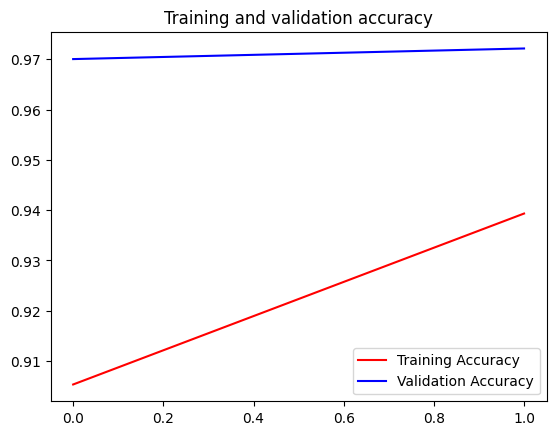

<Figure size 640x480 with 0 Axes>

In [33]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()



### Predict on a test image

You can upload any image and have the model predict whether it's a dog or a cat.
- Find an image of a dog or cat
- Run the following code cell.  It will ask you to upload an image.
- The model will print "is a dog" or "is a cat" depending on the model's prediction.

In [34]:
imag_path = '/content/imag.jpg'
def img_plotter(imag_path):
  plt.rcParams["figure.figsize"] = [7.00, 3.50]
  plt.rcParams["figure.autolayout"] = True
  im = plt.imread(imag_path)
  fig, ax = plt.subplots()
  im = ax.imshow(im, extent=[0, 300, 0, 300])
  plt.show()

Saving cat.jpeg to cat.jpeg
{'cat.jpeg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xe2\x02\x1cICC_PROFILE\x00\x01\x01\x00\x00\x02\x0clcms\x02\x10\x00\x00mntrRGB XYZ \x07\xdc\x00\x01\x00\x19\x00\x03\x00)\x009acspAPPL\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf6\xd6\x00\x01\x00\x00\x00\x00\xd3-lcms\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\ndesc\x00\x00\x00\xfc\x00\x00\x00^cprt\x00\x00\x01\\\x00\x00\x00\x0bwtpt\x00\x00\x01h\x00\x00\x00\x14bkpt\x00\x00\x01|\x00\x00\x00\x14rXYZ\x00\x00\x01\x90\x00\x00\x00\x14gXYZ\x00\x00\x01\xa4\x00\x00\x00\x14bXYZ\x00\x00\x01\xb8\x00\x00\x00\x14rTRC\x00\x00\x01\xcc\x00\x00\x00@gTRC\x00\x00\x01\xcc\x00\x00\x00@bTRC\x00\x00\x01\xcc\x00\x00\x00@desc\x00\x00\x00\x00\x00\x00\x00\x03c2\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\

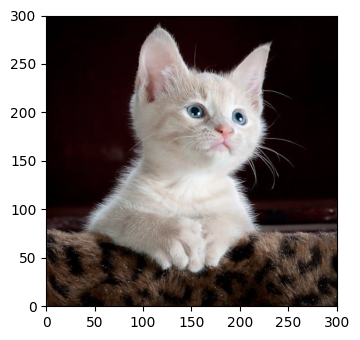

image shape after expanding:  (150, 150, 3)
expanded x shape:  (1, 150, 150, 3)
1/1 [==============================] - 1s 772ms/step
[[7.988657e-10]]
[7.988657e-10]
cat.jpeg is a cat


In [36]:
import numpy as np  # Import numpy library for numerical operations
from google.colab import files  # Import files module from google.colab to upload files
import keras.utils as image  # Import image utilities from Keras

uploaded = files.upload()  # Upload files from local machine to Google Colab environment
print(uploaded)  # Print the uploaded files

for fn in uploaded.keys():  # Loop through the uploaded files

  # predicting images
  path = '/content/' + fn  # Construct the path of the uploaded image
  img_plotter(path)  # Plot the uploaded image
  img = tf.keras.utils.load_img(path, target_size=(150, 150))  # Load and resize the image to target size (150x150)
  x = image.img_to_array(img)  # Convert the image to array
  print('image shape after expanding: ', x.shape)  # Print the shape of the image array
  x = np.expand_dims(x, axis=0)  # Expand the dimensions of the image array
  print('expanded x shape: ', x.shape)  # Print the shape of the expanded image array

  # Perform prediction
  classes = model.predict(x)  # Predict the class probabilities for the image
  print(classes)  # Print the predicted class probabilities
  print(classes[0])  # Print the predicted class probabilities for the first image (assuming only one image is uploaded)

  # Print the prediction result
  if classes[0] > 0.5:
    print(fn + " is a dog")  # If the predicted probability is greater than 0.5, classify as a dog
  else:
    print(fn + " is a cat")  # If the predicted probability is less than or equal to 0.5, classify as a cat


Saving dog.jpg to dog.jpg
{'dog.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\t\x06\x07\x13\x13\x12\x13\x13\x12\x12\x16\x15\x15\x16\x18\x16\x18\x17\x18\x18\x17\x15\x15\x17\x16\x16\x15\x18\x17\x17\x17\x15\x18\x17\x18\x1d( \x1b\x1d(\x1d\x18\x17!2!%)+...\x17\x1f383,7(-.+\x01\n\n\n\x0e\r\x0e\x1a\x10\x10\x1b-%\x1d /+-7---------7---5-------------+--------+--------/\xff\xc0\x00\x11\x08\x00\xd5\x00\xed\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x01\x00\x02\x02\x03\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x04\x06\x05\x07\x02\x03\x08\x01\xff\xc4\x00@\x10\x00\x02\x01\x02\x03\x05\x04\x07\x05\x07\x02\x07\x00\x00\x00\x00\x00\x01\x02\x03\x11\x04!1\x05\x06\x12AQaq\x81\x91\x07\x13"2\xa1\xc1\xf0\x14Rb\xb1\xd1#Br\x82\xb2\xe1\xf1\x92\xa2$34Sc\x93\xc2\xff\xc4\x00\x19\x01\x01\x00\x03\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x03\x04\x05\x01\xff\xc4\x00$\x11\x01\x00\x02\x02\x02\x03\x00\x01\x05\x01\x00\x00\x00\x00\x00\x0

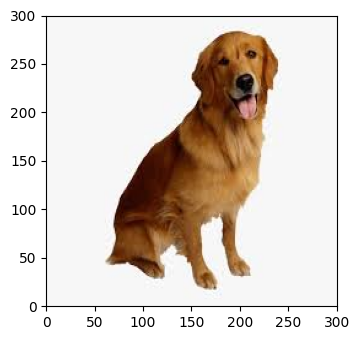

image shape after expanding:  (150, 150, 3)
expanded x shape:  (1, 150, 150, 3)
1/1 [==============================] - 0s 56ms/step
[[3.544183e-24]]
[3.544183e-24]
dog.jpg is a cat


In [39]:
import numpy as np  # Import numpy library for numerical operations
from google.colab import files  # Import files module from google.colab to upload files
import keras.utils as image  # Import image utilities from Keras

uploaded = files.upload()  # Upload files from local machine to Google Colab environment
print(uploaded)  # Print the uploaded files

for fn in uploaded.keys():  # Loop through the uploaded files

  # predicting images
  path = '/content/' + fn  # Construct the path of the uploaded image
  img_plotter(path)  # Plot the uploaded image
  img = tf.keras.utils.load_img(path, target_size=(150, 150))  # Load and resize the image to target size (150x150)
  x = image.img_to_array(img)  # Convert the image to array
  print('image shape after expanding: ', x.shape)  # Print the shape of the image array
  x = np.expand_dims(x, axis=0)  # Expand the dimensions of the image array
  print('expanded x shape: ', x.shape)  # Print the shape of the expanded image array

  # Perform prediction
  classes = model.predict(x)  # Predict the class probabilities for the image
  print(classes)  # Print the predicted class probabilities
  print(classes[0])  # Print the predicted class probabilities for the first image (assuming only one image is uploaded)

  # Print the prediction result
  if classes[0] > 0.5:
    print(fn + " is a dog")  # If the predicted probability is greater than 0.5, classify as a dog
  else:
    print(fn + " is a cat")  # If the predicted probability is less than or equal to 0.5, classify as a cat
